In [1]:
import time
start = time.time()

In [2]:
import os
# Landsat quirk #1
os.environ["AWS_REQUEST_PAYER"] = "requester" 


In [3]:
aoi_filename = "./siouxfalls2.geojson"

# read in AOI as a GeoDataFrame
import geopandas as gpd
aoi = gpd.read_file(aoi_filename)

# get the geometry of the AOI as a dictionary for use with PySTAC Client
from shapely.geometry import mapping
geom = mapping(aoi.to_dict()['geometry'][0])

In [4]:
# STAC API - Landsat Collection 2
url = "https://landsatlook.usgs.gov/stac-server"

# Search parameters
params = {
    "collections": ["landsat-c2l2-sr"],
    "intersects": geom,
    "datetime": "2020-05-01/2021-12-31",
    "limit": 100,
    "query": ["platform=LANDSAT_8", "eo:cloud_cover<5"]
}

from pystac_client import Client
cat = Client.open(url)
search = cat.search(**params)

matched = search.matched()
print(f"{search.matched()} scenes found")

14 scenes found


In [5]:
%%time
from pystac import ItemCollection

# get all items found in search
items_dict = []
for item in search.get_all_items_as_dict()['features']:
    for a in item['assets']:
        if 'alternate' in item['assets'][a] and 's3' in item['assets'][a]['alternate']:
            item['assets'][a]['href'] = item['assets'][a]['alternate']['s3']['href']
        # item['assets'][a]['href'] = item['assets'][a]['href'].replace('usgs-landsat-ard', 'usgs-landsat')
    items_dict.append(item)

# Create GeoDataFrame from resulting Items
#items_gdf = items_to_geodataframe(items_dict)
item_collection = ItemCollection(items_dict)

CPU times: user 12.3 ms, sys: 2.51 ms, total: 14.8 ms
Wall time: 132 ms


In [6]:
import yaml

from odc import stac
from pyproj import CRS
from pystac.extensions.projection import ProjectionExtension

def open_odc(items, crs=None, resolution=None):
    configuration_str = """---
        landsat-c2l2-sr:
          measurements:
            '*':
              dtype: float32
              nodata: 0
              units: 'm'
        """
    configuration = yaml.load(configuration_str, Loader=yaml.CSafeLoader)
    datasets = list(stac.stac2ds(items, configuration))
    
    proj = ProjectionExtension.ext(items[0])
    if crs is None:
        crs = CRS.from_epsg(proj.epsg)
    if resolution is None:
        resolution = (proj.transform[4], proj.transform[0])

    data = stac.dc_load(datasets, chunks={"x": 1024, "y": 1024}, output_crs=crs, resolution=resolution)
    #data = stac.dc_load(datasets, output_crs=crs, resolution=resolution)
    return data

In [7]:
help(stac.dc_load)

Help on function dc_load in module odc.stac._dcload:

dc_load(datasets: Iterable[datacube.model.Dataset], measurements: Union[str, Sequence[str], NoneType] = None, geobox: Union[datacube.utils.geometry._base.GeoBox, NoneType] = None, groupby: Union[str, NoneType] = None, resampling: Union[str, Dict[str, str], NoneType] = None, skip_broken_datasets: bool = False, chunks: Union[Dict[str, int], NoneType] = None, progress_cbk: Union[Callable[[int, int], Any], NoneType] = None, fuse_func=None, **kw) -> xarray.core.dataset.Dataset
    Load data given a collection of datacube.Dataset objects.



In [8]:
_datacube = open_odc(item_collection)

In [9]:
_datacube

,Array,Chunk
Bytes,2.71 GiB,2.00 MiB
Shape,"(14, 8361, 12411)","(1, 1024, 1024)"
Count,1656 Tasks,1638 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk
Bytes,2.71 GiB,2.00 MiB
Shape,"(14, 8361, 12411)","(1, 1024, 1024)"
Count,1656 Tasks,1638 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk


In [10]:
#_datacube.red.plot.imshow(col="time")


In [11]:
import rioxarray

datacube = _datacube.rio.clip([geom], crs='epsg:4326')

In [12]:
datacube

<xarray.Dataset>
Dimensions:      (time: 14, x: 605, y: 683)
Coordinates:
  * y            (y) float64 4.837e+06 4.837e+06 ... 4.816e+06 4.816e+06
  * x            (x) float64 1.891e+05 1.891e+05 ... 2.072e+05 2.072e+05
  * time         (time) datetime64[ns] 2020-06-13T17:11:24.796711 ... 2021-10...
    spatial_ref  int64 0
Data variables:
    coastal      (time, y, x) uint16 dask.array<chunksize=(1, 483, 127), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 483, 127), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 483, 127), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 483, 127), meta=np.ndarray>
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 483, 127), meta=np.ndarray>
    swir16       (time, y, x) uint16 dask.array<chunksize=(1, 483, 127), meta=np.ndarray>
    swir22       (time, y, x) uint16 dask.array<chunksize=(1, 483, 127), meta=np.ndarray>
    qa_aerosol   (time, y, x) uint16 dask.array<chunksize=(1, 483, 127), meta=np.ndarray>
    qa_pixel     (time, y, x) uint16 dask.array<chunksize=(1, 483, 127), meta=np.ndarray>
    qa_radsat    (time, y, x) uint16 dask.array<chunksize=(1, 483, 127), meta=np.ndarray>
Attributes:
    crs:           EPSG:32615
    grid_mapping:  spatial_ref

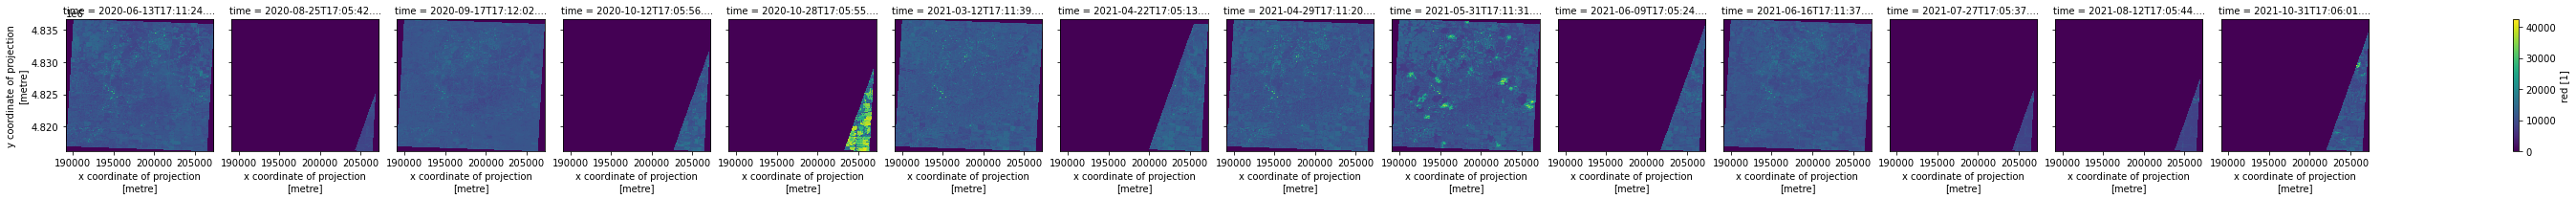

In [13]:
datacube.red.plot.imshow(col="time")


In [14]:
help(datacube.red.plot.imshow)

Help on method imshow in module xarray.plot.plot:

imshow(x, y, **kwargs) method of xarray.plot.plot._PlotMethods instance
    Image plot of 2D DataArray.
    
    Wraps :py:func:`matplotlib:matplotlib.pyplot.imshow`.
    
    While other plot methods require the DataArray to be strictly
    two-dimensional, ``imshow`` also accepts a 3D array where some
    dimension can be interpreted as RGB or RGBA color channels and
    allows this dimension to be specified via the kwarg ``rgb=``.
    
    Unlike :py:func:`matplotlib:matplotlib.pyplot.imshow`, which ignores ``vmin``/``vmax``
    for RGB(A) data,
    xarray *will* use ``vmin`` and ``vmax`` for RGB(A) data
    by applying a single scaling factor and offset to all bands.
    Passing  ``robust=True`` infers ``vmin`` and ``vmax``
    :ref:`in the usual way <robust-plotting>`.
    
    .. note::
        This function needs uniformly spaced coordinates to
        properly label the axes. Call :py:meth:`DataArray.plot` to check.
    
    Th

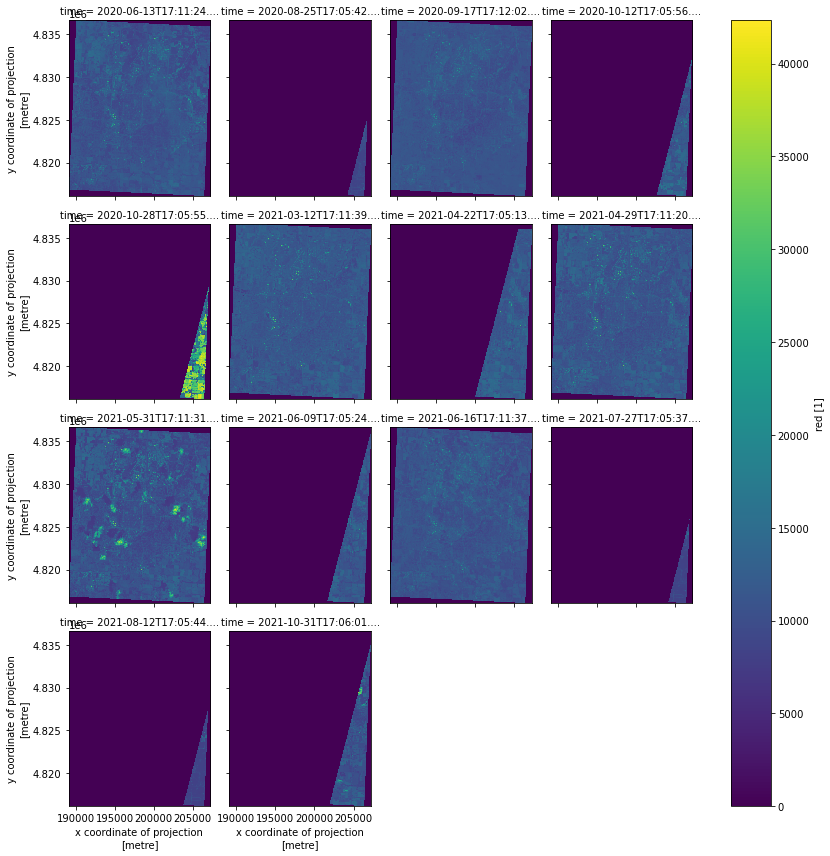

In [15]:
datacube.red.plot.imshow(col="time", col_wrap=4, figsize=(12,12))


In [16]:
from dask.distributed import Client, progress


client = Client()
client

Client Scheduler: tcp://127.0.0.1:36599 Dashboard: /user/butzer@contractor.usgs.gov/proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 15.00 GiB


In [17]:
DS=datacube

In [18]:
da_ndwi = (DS['green'] - DS['swir16']) / (DS['green'] + DS['swir16'])

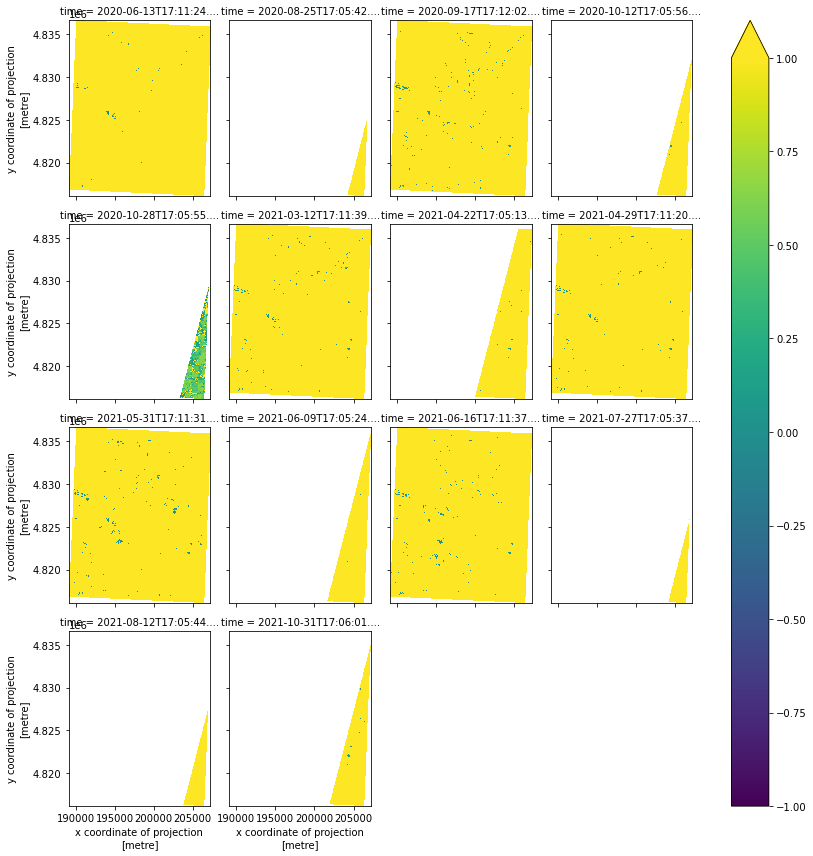

In [19]:
da_ndwi.plot.imshow(col="time", col_wrap=4, figsize=(12,12), vmin=-1, vmax=1)


In [20]:
da_ndwi

<xarray.DataArray (time: 14, y: 683, x: 605)>
dask.array<truediv, shape=(14, 683, 605), dtype=float64, chunksize=(1, 483, 478), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.837e+06 4.837e+06 ... 4.816e+06 4.816e+06
  * x            (x) float64 1.891e+05 1.891e+05 ... 2.072e+05 2.072e+05
  * time         (time) datetime64[ns] 2020-06-13T17:11:24.796711 ... 2021-10...
    spatial_ref  int64 0

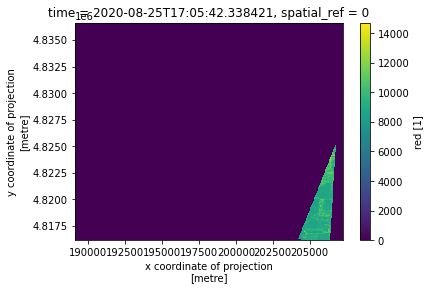

In [21]:
datacube['red'][1].plot()

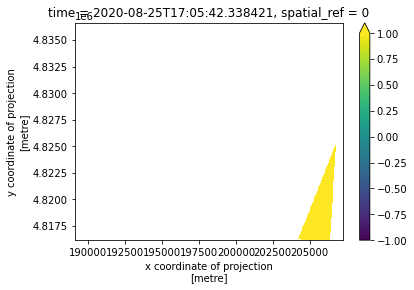

In [22]:
da_ndwi[1].plot(vmin=-1,vmax=1)

(array([   7.,   64.,  353.,  724., 1175., 1781., 3255., 2693.,  941.,
          80.]),
 array([1.66212501, 1.79175335, 1.92138168, 2.05101001, 2.18063834,
        2.31026668, 2.43989501, 2.56952334, 2.69915167, 2.82878001,
        2.95840834]),
 <BarContainer object of 10 artists>)

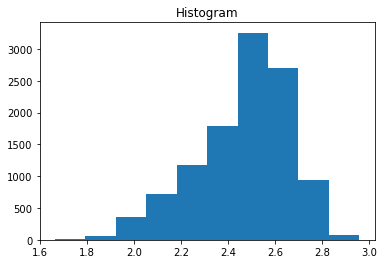

In [23]:
da_ndwi[1].plot.hist()

In [24]:
import sys

sys.path.append('.')

from nb_DEAPlotting import animated_timeseries

In [25]:
# animated_timeseries(datacube,output_path='./siouxfall_L8lowres_animation.gif',bands = ['red', 'green', 'blue'], time_dim='time',  
#       percentile_stretch=(.2,.85), interval=1200)

In [26]:
DS.time.attrs = {}  #this allowed the nc to be written
#DS.SCL.attrs = {}
ds1 = DS.drop(labels='spatial_ref')

In [27]:
! rm sf_all_bands.nc

In [28]:
help(ds1.to_netcdf)

Help on method to_netcdf in module xarray.core.dataset:

to_netcdf(path=None, mode: str = 'w', format: str = None, group: str = None, engine: str = None, encoding: Mapping = None, unlimited_dims: Iterable[Hashable] = None, compute: bool = True, invalid_netcdf: bool = False) -> Union[bytes, ForwardRef('Delayed'), NoneType] method of xarray.core.dataset.Dataset instance
    Write dataset contents to a netCDF file.
    
    Parameters
    ----------
    path : str, Path or file-like, optional
        Path to which to save this dataset. File-like objects are only
        supported by the scipy engine. If no path is provided, this
        function returns the resulting netCDF file as bytes; in this case,
        we need to use scipy, which does not support netCDF version 4 (the
        default format becomes NETCDF3_64BIT).
    mode : {"w", "a"}, default: "w"
        Write ('w') or append ('a') mode. If mode='w', any existing file at
        this location will be overwritten. If mode='a', e

In [29]:
ds1.to_netcdf('sf_all_bands.nc')

In [30]:
"the code you want to test stays here"
end = time.time()
print(end - start)

109.58129906654358
